# A better Dropout! Implementing DropBlock in PyTorch

DropBlock is available on [glasses](https://github.com/FrancescoSaverioZuppichini/glasses) my computer vision library!

## Introduction
Today we are going to implement DropBlock in PyTorch! [DropBlock](https://arxiv.org/abs/1810.12890) introduced by Ghiasi et al is a regularization technique specifical crafter for images that empirically works better than Dropout. By why Dropout is not sufficient? 


### The problem with Dropout on images
[Dropout](https://jmlr.org/papers/v15/srivastava14a.html) is a regularization method that randomly drops (set to zeros) parts of the input before passing it to the next layer. If you are not familiar with it, I suggest the [this](https://cs231n.github.io/neural-networks-2/) lecture notes from Standford (jump to the dropout section). If we want to use it in PyTorch, we can directly import it from the library. Let's see an example!

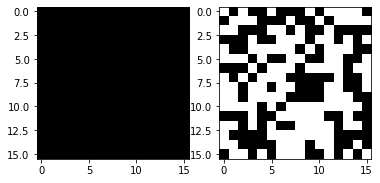

In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn

# keeping one channel for better visualisation
x = torch.ones((1, 1, 16, 16))

drop = nn.Dropout()
x_drop = drop(x)

to_plot = lambda x: x.squeeze(0).permute(1,2,0).numpy()

fig, axs = plt.subplots(1, 2)
axs[0].imshow(to_plot(x), cmap='gray')
axs[1].imshow(to_plot(x_drop), cmap='gray')

As you can see, random pixels of the input were dropped!

This technique works well on 1D data, but with 2D data, we can do better. 

The **main issue** is that we are dropping independent pixels and this *is not effective in removing semantic information because nearby activations contain
closely related information*. I think this is fairly intuitive, even if we zero out one element, the neighbors can still carry out important information.

Let's explore what happens with the feature map. In the following code, we are first getting a baby yoda image, then we create a pretrained resnet18 using [glasses](https://github.com/FrancescoSaverioZuppichini/glasses). Then we feed into the image and get the feature map from the second layer. Finally, we show the activation of the first channel with and without `Dropout`

In [2]:
import requests
from glasses.models import AutoModel, AutoTransform
from PIL import Image
from io import BytesIO

# get an image of baby yoda
r = requests.get('https://upload.wikimedia.org/wikipedia/en/0/00/The_Child_aka_Baby_Yoda_%28Star_Wars%29.jpg')
img = Image.open(BytesIO(r.content))
# use glasses to transform it to the right format
x = AutoTransform.from_name('resnet18')(img)
# get a pretrained resnet18
model = AutoModel.from_pretrained('resnet18').eval()

with torch.no_grad():
    model.encoder.features
    model(x.unsqueeze(0))
    features = model.encoder.features
    # features is a list of layer's outputs 

/home/zuppif/anaconda3/envs/dl/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


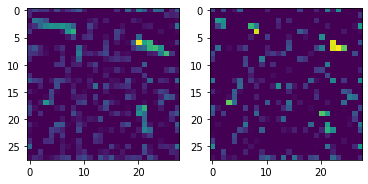

In [3]:
# take the feature from the third layer -> [1, 128, 28, 28]
f = features[2]
# aplpy dropout + relu
f_drop = nn.Sequential(
    nn.Dropout(),
    nn.ReLU())(f)
# apply only relu 
f_l = nn.ReLU()(f)
# get first channel
f_l = f_l[:,0,:,:]
f_drop_l = f_drop[:,0,:,:]

fig, axs = plt.subplots(1, 2)
axs[0].imshow(f_l.squeeze().numpy())
axs[1].imshow(f_drop_l.squeeze().numpy())

On the left, we have the feature map's activations, on the right the activations of the same feature map after dropout. They look very similar, notice how in each region, even if some units are zero, neighbors activation is still firing. This means, information will be propagated to the next layer, that's not ideal.


## DropBlock

DropBlock solves this problem by dropping continuous regions from a feature map, the following figure shows the main idea.

![img](./images/1.png)

Dropblock works as follow

![img](./images/2.png)

Let's go step by step

### Implementation

We can start by defining a `DropBlock` layer with the correct parameters

In [4]:
from torch import nn
import torch
from torch import Tensor

class DropBlock(nn.Module):
    def __init__(self, block_size: int, p: float = 0.5):
        self.block_size = block_size
        self.p = p

`block_size` is the size of each region we are going to drop from an input, `p` is the `keep_prob` like in `Dropout`.

So far so good. Now the tricky part, we need to compute gamma that controls the features to drop. If we want to keep every activation with `p` prob, we can sample from a Bernoulli distribution with mean `1 - p` like in Dropout. The problem is we are setting to zeros `block_size ** 2` units.

Gamma is computed using


\begin{equation}
\gamma=\frac{1-\text { keep_prob }}{\text { block_size }^{2}} \frac{\text { feat_size }^{2}}{(\text { feat_size }-\text { block_size }+1)^{2}}
\end{equation}

The left-hand side of the multiplication is the number of units that will be set to zero. While the right-hand side is the valid region, the number of pixels not touched by dropblock

In [5]:
class DropBlock(nn.Module):
    def __init__(self, block_size: int, p: float = 0.5):
        self.block_size = block_size
        self.p = p


    def calculate_gamma(self, x: Tensor) -> float:
        """Compute gamma, eq (1) in the paper
        Args:
            x (Tensor): Input tensor
        Returns:
            Tensor: gamma
        """
        
        invalid = (1 - self.p) / (self.block_size ** 2)
        valid = (x.shape[-1] ** 2) / ((x.shape[-1] - self.block_size + 1) ** 2)
        return invalid * valid
    
x = torch.ones(1, 8, 16, 16)
DropBlock(block_size=2).calculate_gamma(x)

0.14222222222222222

The next step is to sample a mask $M$ with the same size as the input from a Bernoulli distribution with center gamma, in PyTorch is as easy as

```
# x is the input
gamma = self.calculate_gamma(x)
mask = torch.bernoulli(torch.ones_like(x) * gamma)
```

Next, we need to zero out regions of size `block_size`. We can use **max pool** with `kernel_size` equal to `block_size` and one pixel stride to create. Remember that mask is a binary mask (only 0s and 1s) so when maxpool sees a 1 in his kernel_size radius it will output a one, by using a 1 stride we ensure that in the output a region of size `block_size x block_size` is created if at least one unit in the input was set to 1. Since we want to zero them out, we need to invert it. In PyTorch


```
mask_block = 1 - F.max_pool2d(
                mask,
                kernel_size=(self.block_size, self.block_size),
                stride=(1, 1),
                padding=(self.block_size // 2, self.block_size // 2),
            )
            
```

Then we normalize

```
x = mask_block * x * (mask_block.numel() / mask_block.sum())
```

In [6]:
import torch.nn.functional as F

class DropBlock(nn.Module):
    def __init__(self, block_size: int, p: float = 0.5):
        super().__init__()
        self.block_size = block_size
        self.p = p


    def calculate_gamma(self, x: Tensor) -> float:
        """Compute gamma, eq (1) in the paper
        Args:
            x (Tensor): Input tensor
        Returns:
            Tensor: gamma
        """
        
        invalid = (1 - self.p) / (self.block_size ** 2)
        valid = (x.shape[-1] ** 2) / ((x.shape[-1] - self.block_size + 1) ** 2)
        return invalid * valid



    def forward(self, x: Tensor) -> Tensor:
        if self.training:
            gamma = self.calculate_gamma(x)
            mask = torch.bernoulli(torch.ones_like(x) * gamma)
            mask_block = 1 - F.max_pool2d(
                mask,
                kernel_size=(self.block_size, self.block_size),
                stride=(1, 1),
                padding=(self.block_size // 2, self.block_size // 2),
            )
            x = mask_block * x * (mask_block.numel() / mask_block.sum())
        return x

            

Let's test it with baby yoda, for simplicity, we are going to show the dropped unit in the first channel

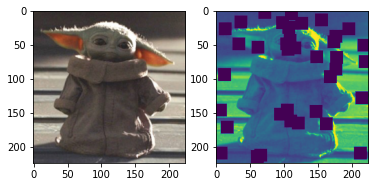

In [7]:
import torchvision.transforms as T
# get an image of baby yoda
r = requests.get('https://upload.wikimedia.org/wikipedia/en/0/00/The_Child_aka_Baby_Yoda_%28Star_Wars%29.jpg')
img = Image.open(BytesIO(r.content))
tr = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])
x = tr(img)
drop_block = DropBlock(block_size=19, p=0.8)
x_drop = drop_block(x)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(to_plot(x))
axs[1].imshow(x_drop[0,:,:].squeeze().numpy())

Looking good, let's see a feature map from a pretrained model (like before)

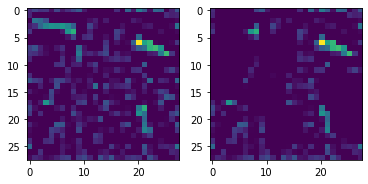

In [8]:
# take the feature from the third layer -> [1, 128, 28, 28]
f = features[2]
# aplpy dropout + relu
f_drop = nn.Sequential(
    DropBlock(block_size=7, p=0.5),
    nn.ReLU())(f)
# apply only relu 
f_l = nn.ReLU()(f)
# get first channel
f_l = f_l[:,0,:,:]
f_drop_l = f_drop[:,0,:,:]

fig, axs = plt.subplots(1, 2)
axs[0].imshow(f_l.squeeze().numpy())
axs[1].imshow(f_drop_l.squeeze().numpy())

We successfully zero out continuous regions and not only individual units.

By the way, `DropBlock` is equal to `Dropout` when `block_size = 1` and to `Dropout2d`(aka SpatialDropout) when `block_size` is the full feature map. 

## Conclusions
Now we know how to implement DropBlock in PyTorch, a cool regularization technique. The paper shows different empirical results. They first use a vanilla resnet50 and iterativaly add different regularization, this is shown in the following table


![png](https://github.com/FrancescoSaverioZuppichini/DropBlock/blob/main/images/resnet50.png?raw=true)

As you can see, `ResNet-50 + DropBlock` archieves + 1% compared by SpatialDropout (the classic `Dropout2d` in PyTorch).

There more tests using different `p` and `block_sizes`, if you are interested go and have a look at the [paper](https://arxiv.org/pdf/1810.12890.pdf)

Thank you for reading!

Francesco